In [1]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import random
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')
from colossus.halo import concentration, mass_defs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from pylab import rcParams
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'
rcParams['font.family'] = 'serif'
rc('text.latex',preamble=r'\usepackage{/Volumes/Extreme_SSD/codes/master_thesis/code/apjfonts}')
from tqdm import tqdm
import lensing_estimator
from cosmo import CosmoCalc
import lensing
import foregrounds as fg
import experiments as exp
import sims
import ilc
import stats
import tools

## Estimator Validation

In [2]:
nber_clus = 3000
nber_rand = 30000
nber_cov = 250
map_params = [240, 0.25, 240, 0.25]
l, cl = CosmoCalc().cmb_power_spectrum()
l, bl = exp.beam_power_spectrum(beam_fwhm = 1.4)
l, nl = exp.noise_power_spectrum(noiseval_white = 2.0)
l, nl_deconvolved =  exp.noise_power_spectrum(noiseval_white = 2.0, beam_fwhm = 1.4)
cl_noise =  nl_deconvolved
nber_clus_fit = 30000 
nber_rand_fit = 30000
mass_int = np.arange(0, 12, 0.2)  
           

#covariance_matrix, correlation_matrix = lensing_estimator.covariance_matrix(nber_clus, nber_rand, nber_cov, map_params,  l, cl, bl = bl, nl = nl, cl_noise = cl_noise)
with open('covariance_matrix.npy', 'rb') as file:
       covariance_matrix = np.load(file)   
        

#dipole_profile_models = lensing_estimator.fit_profiles(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int*1e14, 3, 1, bl = bl, nl = nl, cl_noise = cl_noise)
with open('dipole_profile_models.npy', 'rb') as file:
       dipole_profile_models = np.load(file)    

             

            
lk_arr_2e14 = []      
lk_arr_6e14 = []  
lk_arr_10e14 = []  
for i in tqdm(range(25)):    
    maps_2e14, maps_6e14, maps_10e14 = sims.cmb_test_data(nber_clus, validation_analyis = True)
    maps_rand = sims.cmb_mock_data(nber_rand, map_params, l, cl,  bl = bl, nl = nl)
    bins_2e14, dipole_profile_2e14, stacks_2e14 = lensing_estimator.get_dipole_profile(map_params, maps_2e14, maps_rand,  l, cl, cl_noise)
    bins_6e14, dipole_profile_6e14, stacks_6e14 = lensing_estimator.get_dipole_profile(map_params, maps_6e14, maps_rand,  l, cl, cl_noise)
    bins_10e14, dipole_profile_10e14, stacks_10e14 = lensing_estimator.get_dipole_profile(map_params, maps_10e14, maps_rand,  l, cl, cl_noise)
    data_2e14 = bins_2e14, dipole_profile_2e14, covariance_matrix
    data_6e14 = bins_6e14, dipole_profile_6e14, covariance_matrix
    data_10e14 = bins_10e14, dipole_profile_10e14, covariance_matrix
   
    likelihood_2e14, _, _ = stats.run_ml(data_2e14, dipole_profile_models, mass_int)
    mass_int_lk_2e14, lk_2e14 = likelihood_2e14
    likelihood_6e14, _, _ = stats.run_ml(data_6e14, dipole_profile_models, mass_int)
    mass_int_lk_6e14, lk_6e14 = likelihood_6e14
    likelihood_10e14, _, _ = stats.run_ml(data_10e14, dipole_profile_models, mass_int)
    mass_int_lk_10e14, lk_10e14 = likelihood_10e14
    lk_arr_2e14.append(lk_2e14)
    lk_arr_6e14.append(lk_6e14)
    lk_arr_10e14.append(lk_10e14)

    del maps_2e14
    del maps_6e14
    del maps_10e14
    del maps_rand
    
with open('lk_arr_2e14.npy', 'wb') as file:
    np.save(file, lk_arr_2e14) 
    
with open('lk_arr_6e14.npy', 'wb') as file:
    np.save(file, lk_arr_6e14) 
    
with open('lk_arr_10e14.npy', 'wb') as file:
    np.save(file, lk_arr_10e14) 
    
    
    
    
comb_lk_2e14 = np.ones(len(lk_arr_2e14[0]))
for i in range(25):
    comb_lk_2e14 *= lk_arr_2e14[i]
comb_lk_2e14 = comb_lk_2e14/max(comb_lk_2e14)
mean_mass, errors = stats.ml_params(mass_int_lk_2e14, comb_lk_2e14)      
print(mean_mass, (errors[0]+errors[1])/2) 

comb_lk_6e14 = np.ones(len(lk_arr_6e14[0]))
for i in range(25):
    comb_lk_6e14 *= lk_arr_6e14[i]
comb_lk_6e14 = comb_lk_6e14/max(comb_lk_6e14)
mean_mass, errors = stats.ml_params(mass_int_lk_6e14, comb_lk_6e14)      
print(mean_mass,  (errors[0]+errors[1])/2) 
      
comb_lk_10e14 = np.ones(len(lk_arr_10e14[0]))
for i in range(25):
    comb_lk_10e14 *= lk_arr_10e14[i]
comb_lk_10e14 = comb_lk_10e14/max(comb_lk_10e14)
mean_mass, errors = stats.ml_params(mass_int_lk_10e14, comb_lk_10e14)      
print(mean_mass,  (errors[0]+errors[1])/2)   

KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(16,5))
(ax1, ax2, ax3) = axs
for i in range(25):
    ax1.plot(mass_int_lk_2e14[1000:3000], lk_arr_2e14[i][1000:3000], color = 'red', ls='-', alpha = 0.1)
ax1.plot(mass_int_lk_2e14[1000:3000], comb_lk_2e14[1000:3000], color = 'black', ls = '-')
ax1.axvline(2, color = 'green', ls = '--') 
ax1.set_xlabel(r'$M_{200}\ [10^{14}M_\odot]$', fontsize = 15)   
ax1.set_ylabel('Normalized '+r'$\mathcal{L}$', fontsize = 15)
for i in range(25):
    ax2.plot(mass_int_lk_6e14[4500:7500], lk_arr_6e14[i][4500:7500], color = 'red', ls='-', alpha = 0.1)
ax2.plot(mass_int_lk_6e14[4500:7500], comb_lk_6e14[4500:7500], color = 'black', ls = '-')
ax2.axvline(6, color = 'green', ls = '--') 
ax2.set_xlabel(r'$M_{200}\ [10^{14}M_\odot]$', fontsize = 15) 
for i in range(25):
    ax3.plot(mass_int_lk_10e14[8000:12000], lk_arr_10e14[i][8000:12000], color = 'red', ls='-', alpha = 0.1)
ax3.plot(mass_int_lk_10e14[8000:12000], comb_lk_10e14[8000:12000], color = 'black', ls = '-')
ax3.axvline(10, color = 'green', ls = '--') 
ax3.set_xlabel(r'$M_{200}\ [10^{14}M_\odot]$', fontsize = 15) 
plt.savefig('estimator_validation.eps', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)

## Ignoring Magnitude Weights and Noise for Fit Profiles

In [ ]:
nber_clus = 3000
nber_rand = 30000
nber_cov = 250
map_params = [240, 0.25, 240, 0.25]
l, cl = CosmoCalc().cmb_power_spectrum()
l, bl = exp.beam_power_spectrum(beam_fwhm = 1.4)
l, nl = exp.noise_power_spectrum(noiseval_white = 2.0)
l, nl_deconvolved =  exp.noise_power_spectrum(noiseval_white = 2.0, beam_fwhm = 1.4)
cl_noise =  nl_deconvolved
nber_clus_fit = 30000 
nber_rand_fit = 30000
mass_int = np.arange(0, 12, 0.2)  
mass_int_no = np.arange(4, 8, 0.2)  
           

    
#covariance_matrix, correlation_matrix = lensing_estimator.covariance_matrix(nber_clus, nber_rand, nber_cov, map_params,  l, cl, bl = bl, nl = nl, cl_noise = cl_noise)
with open('covariance_matrix.npy', 'rb') as file:
       covariance_matrix = np.load(file)   
        

#dipole_profile_models = lensing_estimator.fit_profiles(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int*1e14, 3, 1, bl = bl, nl = nl, cl_noise = cl_noise)
with open('dipole_profile_models.npy', 'rb') as file:
       dipole_profile_models = np.load(file)    
    
    

covariance_matrix_no_weights, correlation_matrix_no_weights = lensing_estimator.covariance_matrix(nber_clus, nber_rand, nber_cov, map_params,  l, cl, bl = bl, nl = nl, cl_noise = cl_noise, use_magnitude_weights = False)
with open('covariance_matrix_no_weights.npy', 'wb') as file:
    np.save(file, covariance_matrix_no_weights)   
            

dipole_profile_models_no_weights = lensing_estimator.fit_profiles(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_no*1e14, 3, 1, bl = bl, nl = nl, cl_noise = cl_noise, use_magnitude_weights = False)
with open('dipole_profile_models_no_weights.npy', 'wb') as file:
    np.save(file, dipole_profile_models_no_weights)                 

    
dipole_profile_models_no_noise = lensing_estimator.fit_profiles(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_no*1e14, 3, 1, bl = bl, nl = nl, cl_noise = cl_noise, apply_noise = False)
with open('dipole_profile_models_no_noise.npy', 'wb') as file:
    np.save(file, dipole_profile_models_no_noise)    


lk_arr_std = []     
lk_arr_no_weights = []      
lk_arr_no_noise = []  
for i in tqdm(range(25)):    
    _, maps_std,_ = sims.cmb_test_data(nber_clus, validation_analyis = True)
    maps_rand = sims.cmb_mock_data(nber_rand, map_params, l, cl,  bl = bl, nl = nl)
    bins_std, dipole_profile_std, stacks_std = lensing_estimator.get_dipole_profile(map_params, maps_std, maps_rand,  l, cl, cl_noise)
    bins_no_weights, dipole_profile_no_weights, stacks_no_weights = lensing_estimator.get_dipole_profile(map_params, maps_std, maps_rand,  l, cl, cl_noise, use_magnitude_weights = False)
    data_std = bins_std, dipole_profile_std, covariance_matrix
    data_no_weights = bins_no_weights, dipole_profile_no_weights, covariance_matrix_no_weights
   
    likelihood_std, _, _ = stats.run_ml(data_std, dipole_profile_models, mass_int)
    mass_int_lk_std, lk_std = likelihood_std
    likelihood_no_weights, _, _ = stats.run_ml(data_no_weights, dipole_profile_models_no_weights, mass_int_no)
    mass_int_lk_no_weights, lk_no_weights = likelihood_no_weights
    likelihood_no_noise, _, _ = stats.run_ml(data_std, dipole_profile_models_no_noise, mass_int_no)
    mass_int_lk_no_noise, lk_no_noise = likelihood_no_noise
    lk_arr_std.append(lk_std)
    lk_arr_no_weights.append(lk_no_weights)
    lk_arr_no_noise.append(lk_no_noise)

    del maps_std
    del maps_rand
    
    
    
comb_lk_std = np.ones(len(lk_arr_std[0]))
for i in range(25):
    comb_lk_std *= lk_arr_std[i]
comb_lk_std = comb_lk_std/max(comb_lk_std)
mean_mass, errors = stats.ml_params(mass_int_lk_std, comb_lk_std)      
print(mean_mass, (errors[0]+errors[1])/2) 

comb_lk_no_weights = np.ones(len(lk_arr_no_weights[0]))
for i in range(25):
    comb_lk_no_weights *= lk_arr_no_weights[i]
comb_lk_no_weights = comb_lk_no_weights/max(comb_no_weights)
mean_mass, errors = stats.ml_params(mass_int_lk_no_weights, comb_lk_no_weights)      
print(mean_mass, (errors[0]+errors[1])/2) 
      
comb_lk_no_noise = np.ones(len(lk_arr_no_noise[0]))
for i in range(25):
    comb_lk_no_noise *= lk_arr_no_noise[i]
comb_lk_no_noise = comb_lk_no_noise/max(comb_lk__no_noise)
mean_mass, errors = stats.ml_params(mass_int_lk_no_noise, comb_lk_no_noise)      
print(mean_mass, (errors[0]+errors[1])/2) 

In [ ]:
fig, axs = plt.subplots(1, 1, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(10,5))
(ax1) = axs
for i in range(25):
    ax1.plot(mass_int_lk_std[4500:7500], lk_arr_std[i][4500:7500], color = 'red', ls='-', alpha = 0.1)
    ax1.plot(mass_int_lk_no_weights, lk_arr_no_weights[i], color = 'blue', ls='-', alpha = 0.1)
    ax1.plot(mass_int_lk_no_noise, lk_arr_no_noise[i], color = 'violet', ls='-', alpha = 0.1)
ax1.plot(mass_int_lk_std[4500:7500], comb_lk_std[4500:7500], color = 'darkred', ls = '-')
ax1.plot(mass_int_lk_no_weights, comb_lk_no_weights, color = 'darkblue', ls = '-')
ax1.plot(mass_int_lk_no_noise, comb_lk_no_noise, color = 'darkviolet', ls = '-')
ax1.axvline(6, color = 'green', ls = '--') 
ax1.set_xlabel(r'$M_{200}\ [10^{14}M_\odot]$', fontsize = 15)   
ax1.set_ylabel('Normalized '+r'$\mathcal{L}$', fontsize = 15)
plt.savefig('no_weights_no_noise.eps', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)

## Cluster Positions

In [ ]:
nber_clus = 3000
nber_rand = 30000
nber_cov = 250
map_params = [240, 0.25, 240, 0.25]
l, cl = CosmoCalc().cmb_power_spectrum()
centroid_shift = 0.5
l, bl = exp.beam_power_spectrum(beam_fwhm = 1.4)
l, nl = exp.noise_power_spectrum(noiseval_white = 2.0)
l, nl_deconvolved =  exp.noise_power_spectrum(noiseval_white = 2.0, beam_fwhm = 1.4)
cl_noise =  nl_deconvolved
nber_clus_fit = 30000
nber_rand_fit = 30000
mass_int_centroid_shift = np.arange(4, 8, 0.2) 

dipole_profile_models_no_shift = lensing_estimator.fit_profiles(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_centroid_shift*1e14, 3, 1, bl = bl, nl = nl, cl_noise = cl_noise)
with open('dipole_profile_models_no_shift.npy', 'wb') as file:
    np.save(file, dipole_profile_models_no_shift)   

In [ ]:
nber_clus = 3000
nber_rand = 30000
nber_cov = 250
map_params = [240, 0.25, 240, 0.25]
l, cl = CosmoCalc().cmb_power_spectrum()
centroid_shift = 0.5
l, bl = exp.beam_power_spectrum(beam_fwhm = 1.4)
l, nl = exp.noise_power_spectrum(noiseval_white = 2.0)
l, nl_deconvolved =  exp.noise_power_spectrum(noiseval_white = 2.0, beam_fwhm = 1.4)
cl_noise =  nl_deconvolved
nber_clus_fit = 30000
nber_rand_fit = 30000
mass_int_centroid_shift = np.arange(4, 8, 0.2) 


#covariance_matrix, correlation_matrix = lensing_estimator.covariance_matrix(nber_clus, nber_rand, nber_cov, map_params,  l, cl, bl = bl, nl = nl, cl_noise = cl_noise)
with open('covariance_matrix.npy', 'rb') as file:
    covariance_matrix = np.load(file)   
        

#dipole_profile_models_no_shift = lensing_estimator.fit_profiles(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_centroid_shift*1e14, 3, 1, bl = bl, nl = nl, cl_noise = cl_noise)
with open('dipole_profile_models_no_shift.npy', 'rb') as file:
    dipole_profile_models_no_shift = np.load(file)            
        
#dipole_profile_models_centroid_shift = lensing_estimator.fit_profiles(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_centroid_shift*1e14, 3, 1, centroid_shift = centroid_shift, bl = bl, nl = nl, cl_noise = cl_noise)
with open('dipole_profile_models_centroid_shift.npy', 'rb') as file:
    dipole_profile_models_centroid_shift = np.load(file)    

    
    
lk_arr_no_shift, mass_arr_no_shift, error_arr_no_shift = [], [], []      
lk_arr_centroid_shift, mass_arr_centroid_shift, error_arr_centroid_shift = [], [], []   
lk_arr_ignoring, mass_arr_ignoring, error_arr_ignoring = [], [], []
for i in tqdm(range(25)):    
    maps_no_shift, maps_centroid_shift = sims.cmb_test_data(nber_clus, clus_position_analysis = True)
    maps_rand = sims.cmb_mock_data(nber_rand, map_params, l, cl,  bl = bl, nl = nl)
    bins_no_shift, dipole_profile_no_shift, stacks_no_shift = lensing_estimator.get_dipole_profile(map_params, maps_no_shift, maps_rand,  l, cl, cl_noise)
    bins_centroid_shift, dipole_profile_centroid_shift, stacks_centroid_shift = lensing_estimator.get_dipole_profile(map_params, maps_centroid_shift, maps_rand,  l, cl, cl_noise)
    data_no_shift = bins_no_shift, dipole_profile_no_shift, covariance_matrix
    data_centroid_shift = bins_centroid_shift, dipole_profile_centroid_shift, covariance_matrix
   
    likelihood_no_shift, mean_mass_no_shift, errors_no_shift = stats.run_ml(data_no_shift, dipole_profile_models_no_shift, mass_int_centroid_shift)
    likelihood_ignoring, mean_mass_ignoring, errors_ignoring = stats.run_ml(data_centroid_shift, dipole_profile_models_no_shift, mass_int_centroid_shift)
    likelihood_centroid_shift, mean_mass_centroid_shift, errors_centroid_shift = stats.run_ml(data_centroid_shift, dipole_profile_models_centroid_shift, mass_int_centroid_shift)
    mass_int_lk_no_shift, lk_no_shift = likelihood_no_shift
    mass_int_lk_ignoring, lk_ignoring = likelihood_ignoring
    mass_int_lk_centroid_shift, lk_centroid_shift = likelihood_centroid_shift
    lk_arr_no_shift.append(lk_no_shift)
    lk_arr_ignoring.append(lk_ignoring)
    lk_arr_centroid_shift.append(lk_centroid_shift)
    mass_arr_no_shift.append(mean_mass_no_shift)
    mass_arr_ignoring.append(mean_mass_ignoring)
    mass_arr_centroid_shift.append(mean_mass_centroid_shift)
    error_arr_no_shift.append((errors_no_shift[0]+errors_no_shift[1])/2)
    error_arr_ignoring.append((errors_ignoring[0]+errors_ignoring[1])/2)
    error_arr_centroid_shift.append((errors_centroid_shift[0]+errors_centroid_shift[1])/2)
   
    
    
    del maps_no_shift
    del maps_centroid_shift
    del maps_rand

    
with open('mass_arr_no_shift.npy', 'wb') as file:
    np.save(file, mass_arr_no_shift) 
    
with open('mass_arr_ignoring.npy', 'wb') as file:
    np.save(file, mass_arr_ignoring) 
    
with open('mass_arr_centroid_shift.npy', 'wb') as file:
    np.save(file, mass_arr_centroid_shift) 

with open('error_arr_no_shift.npy', 'wb') as file:
    np.save(file, error_arr_no_shift) 
    
with open('error_arr_ignoring.npy', 'wb') as file:
    np.save(file, error_arr_ignoring) 
    
with open('mass_arr_centroid_shift.npy', 'wb') as file:
    np.save(file, error_arr_centroid_shift)
    
    
comb_lk_no_shift = np.ones(len(lk_arr_no_shift[0]))
for i in range(25):
    comb_lk_no_shift *= lk_arr_no_shift[i]
comb_lk_no_shift = comb_lk_no_shift/max(comb_lk_no_shift)
mean_mass_comb_no_shift, errors_comb_no_shift = stats.ml_params(mass_int_lk_no_shift, comb_lk_no_shift)      
print(mean_mass_comb_no_shift, (errors_comb_no_shift[0]+errors_comb_no_shift[1])/2)     
    

comb_lk_ignoring = np.ones(len(lk_arr_ignoring[0]))
for i in range(25):
    comb_lk_ignoring *= lk_arr_ignoring[i]
comb_lk_ignoring = comb_lk_ignoring/max(comb_lk_ignoring)
mean_mass_comb_ignoring, errors_comb_ignoring = stats.ml_params(mass_int_lk_ignoring, comb_lk_ignoring)      
print(mean_mass_comb_ignoring, (errors_comb_ignoring[0]+errors_comb_ignoring[1])/2) 


comb_lk_centroid_shift = np.ones(len(lk_arr_centroid_shift[0]))
for i in range(25):
    comb_lk_centroid_shift *= lk_arr_centroid_shift[i]
comb_lk_centroid_shift = comb_lk_centroid_shift/max(comb_lk_centroid_shift)
mean_mass_comb_centroid_shift, errors_comb_centroid_shift = stats.ml_params(mass_int_lk_centroid_shift, comb_lk_centroid_shift)      
print(mean_mass_comb_centroid_shift, (errors_comb_centroid_shift[0]+errors_comb_centroid_shift[1])/2) 

In [ ]:
fig, ax = plt.subplots()
best_fit_arr = [mass_arr_no_shift, mass_arr_ignoring, mass_arr_centroid_shift]
centers_no_shift = np.asarray(mass_arr_no_shift)-6
centers_ignoring = np.asarray(mass_arr_ignoring)-6
centers_centroid_shift = np.asarray(mass_arr_centroid_shift)-6
centers = [centers_no_shift, centers_ignoring, centers_centroid_shift]
width_arr = [error_arr_no_shift, error_arr_ignoring, error_arr_centroid_shift]
color_arr = ['black', 'red', 'blue']
for cntr, (center, widthval, colorval) in enumerate(zip(centers, width_arr, color_arr )):
    yval = [cntr for i in range(len(mass_arr_no_shift))]
    plt.errorbar(center, yval, xerr = widthval, color = colorval, marker = 'o', ls = '', alpha = 0.05)
plt.errorbar(mean_mass_comb_no_shift-6, 0, xerr = (errors_comb_no_shift[0]+errors_comb_no_shift[1])/2, color = 'black', marker = 'o', ls = '')
plt.errorbar(mean_mass_comb_ignoring-6, 1, xerr = (errors_comb_ignoring[0]+errors_ignoring[1])/2, color = 'red', marker = 'o', ls = '')
plt.errorbar(mean_mass_comb_centroid_shift-6, 2, xerr = (errors_comb_centroid_shift[0]+errors_centroid_shift[1])/2, color = 'blue', marker = 'o', ls = '')
plt.axvline(0, color = 'green', ls = '--')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axes.yaxis.set_ticks([])
plt.text(0.6, 0, 'baseline', fontsize = 15)
plt.text(0.6, 1, '+ 0.5\' shift', fontsize = 15)
plt.text(0.6, 2, 'corrected', fontsize = 15)
plt.xlabel(r'$M_{lens}-M_{true}$', fontsize = 15)
plt.savefig('cluster_positions.eps', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)

## Foreground Bias

In [ ]:
nber_clus = 3000
nber_rand = 30000
nber_cov = 250
map_params = [240, 0.25, 240, 0.25]
l, cl = CosmoCalc().cmb_power_spectrum()
c500 = concentration.concentration(2e14, '500c', 0.7)
M200c, _, c200 = mass_defs.changeMassDefinition(2e14, c500, 0.7, '500c', '200c', profile='nfw')
fname = 'sim_data/mdpl2_cutouts_for_tszksz_clus_detection_M1.7e+14to2.3e+14_z0.6to0.8_15320haloes_boxsize20.0am.npz'
cutouts_dic = np.load(fname, allow_pickle = 1, encoding= 'latin1')['arr_0'].item()
mass_z_key = list(cutouts_dic.keys())[0]
cutouts = cutouts_dic[mass_z_key]
scale_fac = fg.compton_y_to_delta_Tcmb(freq = 150, uK = True)
tsz_cutouts, ksz_cutouts, tsz_ksz_cutouts = [], [], []
for kcntr, keyname in enumerate( cutouts ):
    tsz_cutout = cutouts[keyname]['y']*scale_fac
    tsz_cutouts.append(tsz_cutout)
    ksz_cutout = cutouts[keyname]['ksz']*random.randrange(-1, 2, 2)
    ksz_cutouts.append(ksz_cutout)
    tsz_ksz_cutout = tsz_cutout + ksz_cutout
    tsz_ksz_cutouts.append(tsz_ksz_cutout)   
l, bl = exp.beam_power_spectrum(beam_fwhm = 1.4)
l, nl = exp.noise_power_spectrum(noiseval_white = 2.0)
l, nl_deconvolved =  exp.noise_power_spectrum(noiseval_white = 2.0, beam_fwhm = 1.4)
cl_noise =  nl_deconvolved
nber_clus_fit = 30000 
nber_rand_fit = 30000
mass_int_bias = np.arange(0, 6, 0.2) 
           

#covariance_matrix, correlation_matrix = lensing_estimator.covariance_matrix(nber_clus, nber_rand, nber_cov, map_params,  l, cl, bl = bl, nl = nl, cl_noise = cl_noise)
with open('covariance_matrix.npy', 'rb') as file:
    covariance_matrix = np.load(file)   
        

        
#covariance_matrix_tsz, correlation_matrix_tsz = lensing_estimator.covariance_matrix(nber_clus, nber_rand, nber_cov, map_params, l, cl, tsz_cutouts, bl = bl, nl = nl, cl_noise = cl_noise)      
with open('covariance_matrix_tsz.npy', 'rb') as file:
    covariance_matrix_tsz = np.load(file)
    
    
#covariance_matrix_ksz, correlation_matrix_ksz = lensing_estimator.covariance_matrix(nber_clus, nber_rand, nber_cov, map_params, l, cl, ksz_cutouts, bl = bl, nl = nl, cl_noise = cl_noise)      
with open('covariance_matrix_ksz.npy', 'rb') as file:
    covariance_matrix_ksz = np.load(file)    
    
    
#covariance_matrix_tsz_ksz, correlation_matrix_tsz_ksz = lensing_estimator.covariance_matrix(nber_clus, nber_rand, nber_cov, map_params, l, cl, tsz_ksz_cutouts, bl = bl, nl = nl, cl_noise = cl_noise)      
with open('covariance_matrix_tsz_ksz.npy', 'rb') as file:
    covariance_matrix_tsz_ksz = np.load(file)       
    

#covariance_matrix_tsz_corrected, correlation_matrix_tsz_corrected = lensing_estimator.covariance_matrix(nber_clus, nber_rand, nber_cov, map_params, l, cl, tsz_cutouts, bl = bl, nl = nl, cl_noise = cl_noise, correct_for_tsz = True)      
with open('covariance_matrix_tsz_corrected.npy', 'rb') as file:
    covariance_matrix_tsz_corrected = np.load(file)
    
    
#covariance_matrix_tsz_ksz_corrected, correlation_matrix_tsz_ksz_corrected = lensing_estimator.covariance_matrix(nber_clus, nber_rand, nber_cov, map_params, l, cl, tsz_ksz_cutouts, bl = bl, nl = nl, cl_noise = cl_noise, correct_for_tsz = True)      
with open('covariance_matrix_tsz_ksz_corrected.npy', 'rb') as file:
    covariance_matrix_tsz_ksz_corrected = np.load(file)
  
        
#dipole_profile_models_bias = lensing_estimator.fit_profiles(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_bias*1e14, c200, 0.7, bl = bl, nl =nl, cl_noise = cl_noise)
with open('dipole_profile_models_foregrounds.npy', 'rb') as file:
    dipole_profile_models_bias = np.load(file)

    
lk_arr_baseline, mass_arr_baseline, error_arr_baseline = [], [], []      
lk_arr_tsz, mass_arr_tsz, error_arr_tsz = [], [], []      
lk_arr_ksz, mass_arr_ksz, error_arr_ksz = [], [], []  
lk_arr_tsz_ksz, mass_arr_tsz_ksz, error_arr_tsz_ksz = [], [], []
lk_arr_tsz_corrected, mass_arr_tsz_corrected, error_arr_tsz_corrected = [], [], []
lk_arr_tsz_ksz_corrected, mass_arr_tsz_ksz_corrected, error_arr_tsz_ksz_corrected = [], [], []
for i in tqdm(range(25)):    
    maps_baseline, maps_tsz, maps_ksz, maps_tsz_ksz = sims.cmb_test_data(nber_clus, extragal_bias_analysis = True)
    maps_rand = sims.cmb_mock_data(nber_rand, map_params, l, cl,  bl = bl, nl = nl)
    bins_baseline, dipole_profile_baseline, stacks_baseline = lensing_estimator.get_dipole_profile(map_params, maps_baseline, maps_rand,  l, cl, cl_noise)
    bins_tsz, dipole_profile_tsz, stacks_tsz = lensing_estimator.get_dipole_profile(map_params, maps_tsz, maps_rand,  l, cl, cl_noise)
    bins_ksz, dipole_profile_ksz, stacks_ksz = lensing_estimator.get_dipole_profile(map_params, maps_ksz, maps_rand,  l, cl, cl_noise)
    bins_tsz_ksz, dipole_profile_tsz_ksz, stacks_tsz_ksz = lensing_estimator.get_dipole_profile(map_params, maps_tsz_ksz, maps_rand,  l, cl, cl_noise)
    bins_tsz_corrected, dipole_profile_tsz_corrected, stacks_tsz_corrected = lensing_estimator.get_dipole_profile(map_params, maps_tsz, maps_rand,  l, cl, cl_noise, correct_for_tsz = True)
    bins_tsz_ksz_corrected, dipole_profile_tsz_ksz_corrected, stacks_tsz_ksz_corrected = lensing_estimator.get_dipole_profile(map_params, maps_tsz_ksz, maps_rand, l, cl, cl_noise, correct_for_tsz = True)
    data_baseline = bins_baseline, dipole_profile_baseline, covariance_matrix
    data_tsz = bins_tsz, dipole_profile_tsz, covariance_matrix_tsz
    data_ksz = bins_ksz, dipole_profile_ksz, covariance_matrix_ksz
    data_tsz_ksz = bins_tsz_ksz, dipole_profile_tsz_ksz, covariance_matrix_tsz_ksz
    data_tsz_corrected = bins_tsz_corrected, dipole_profile_tsz_corrected, covariance_matrix_tsz_corrected
    data_tsz_ksz_corrected = bins_tsz_ksz_corrected, dipole_profile_tsz_ksz_corrected, covariance_matrix_tsz_ksz_corrected
    
   
    likelihood_baseline, mean_mass_baseline, errors_baseline = stats.run_ml(data_baseline, dipole_profile_models_bias, mass_int_bias)
    mass_int_lk_baseline, lk_baseline = likelihood_baseline
    likelihood_tsz, mean_mass_tsz, errors_tsz = stats.run_ml(data_tsz, dipole_profile_models_bias, mass_int_bias)
    mass_int_lk_tsz, lk_tsz = likelihood_tsz
    likelihood_ksz, mean_mass_ksz, errors_ksz = stats.run_ml(data_ksz, dipole_profile_models_bias, mass_int_bias)
    mass_int_lk_ksz, lk_ksz = likelihood_ksz
    likelihood_tsz_ksz, mean_mass_tsz_ksz, errors_tsz_ksz = stats.run_ml(data_tsz_ksz, dipole_profile_models_bias, mass_int_bias)
    mass_int_lk_tsz_ksz, lk_tsz_ksz = likelihood_tsz_ksz
    likelihood_tsz_corrected, mean_mass_tsz_corrected, errors_tsz_corrected = stats.run_ml(data_tsz_corrected, dipole_profile_models_bias, mass_int_bias)
    mass_int_lk_tsz_corrected, lk_tsz_corrected = likelihood_tsz_corrected
    likelihood_tsz_ksz_corrected, mean_mass_tsz_ksz_corrected, errors_tsz_ksz_corrected = stats.run_ml(data_tsz_ksz_corrected, dipole_profile_models_bias, mass_int_bias)
    mass_int_lk_tsz_ksz_corrected, lk_tsz_ksz_corrected = likelihood_tsz_ksz_corrected
    lk_arr_baseline.append(lk_baseline)
    lk_arr_tsz.append(lk_tsz)
    lk_arr_ksz.append(lk_ksz)
    lk_arr_tsz_ksz.append(lk_tsz_ksz)
    lk_arr_tsz_corrected.append(lk_tsz_corrected)
    lk_arr_tsz_ksz_corrected.append(lk_tsz_ksz_corrected)
    mass_arr_baseline.append(mean_mass_baseline)
    mass_arr_tsz.append(mean_mass_tsz)
    mass_arr_ksz.append(mean_mass_ksz)
    mass_arr_tsz_ksz.append(mean_mass_tsz_ksz)
    mass_arr_tsz_corrected.append(mean_mass_tsz_corrected)
    mass_arr_tsz_ksz_corrected.append(mean_mass_tsz_ksz_corrected)   
    error_arr_baseline.append((errors_baseline[0]+errors_baseline[1])/2)
    error_arr_tsz.append((errors_tsz[0]+errors_tsz[1])/2)
    error_arr_ksz.append((errors_ksz[0]+errors_ksz[1])/2)
    error_arr_tsz_ksz.append((errors_tsz_ksz[0]+errors_tsz_ksz[1])/2)
    error_arr_tsz_corrected.append((errors_tsz_corrected[0]+errors_tsz_corrected[1])/2)
    error_arr_tsz_ksz_corrected.append((errors_tsz_ksz_corrected[0]+errors_tsz_ksz_corrected[1])/2)  
    
    del maps_rand 
    del maps_baseline
    del maps_tsz
    del maps_ksz
    del maps_tsz_ksz

    
comb_lk_baseline = np.ones(len(lk_arr_baseline[0]))
for i in range(25):
    comb_lk_baseline *= lk_arr_baseline[i]
comb_lk_baseline = comb_lk_baseline/max(comb_lk_baseline)
mean_mass_comb_baseline, errors_comb_baseline = stats.ml_params(mass_int_lk_baseline, comb_lk_baseline)      
print(mean_mass_comb_baseline, (errors_comb_baseline[0]+errors_comb_baseline[1])/2)    
    
    
comb_lk_tsz = np.ones(len(lk_arr_tsz[0]))
for i in range(25):
    comb_lk_tsz *= lk_arr_tsz[i]
comb_lk_tsz = comb_lk_tsz/max(comb_lk_tsz)
mean_mass_comb_tsz, errors_comb_tsz = stats.ml_params(mass_int_lk_tsz, comb_lk_tsz)      
print(mean_mass_comb_tsz, (errors_comb_tsz[0]+errors_comb_tsz[1])/2) 

comb_lk_ksz = np.ones(len(lk_arr_ksz[0]))
for i in range(25):
    comb_lk_ksz *= lk_arr_ksz[i]
comb_lk_ksz = comb_lk_ksz/max(comb_lk_ksz)
mean_mass_comb_ksz, errors_comb_ksz = stats.ml_params(mass_int_lk_ksz, comb_lk_ksz)      
print(mean_mass_comb_ksz, (errors_comb_ksz[0]+errors_comb_ksz[1])/2) 
      
comb_lk_tsz_ksz = np.ones(len(lk_arr_tsz_ksz[0]))
for i in range(25):
    comb_lk_tsz_ksz *= lk_arr_tsz_ksz[i]
comb_lk_tsz_ksz = comb_lk_tsz_ksz/max(comb_lk_tsz_ksz)
mean_mass_comb_tsz_ksz, errors_comb_tsz_ksz = stats.ml_params(mass_int_lk_tsz_ksz, comb_lk_tsz_ksz)      
print(mean_mass_comb_tsz_ksz, (errors_comb_tsz_ksz[0]+errors_comb_tsz_ksz[1])/2)       

comb_lk_tsz_corrected = np.ones(len(lk_arr_tsz_corrected[0]))
for i in range(25):
    comb_lk_tsz_corrected *= lk_arr_tsz_corrected[i]
comb_lk_tsz_corrected = comb_lk_tsz_corrected/max(comb_lk_tsz_corrected)
mean_mass_comb_tsz_corrected, errors_comb_tsz_corrected = stats.ml_params(mass_int_lk_tsz_corrected, comb_lk_tsz_corrected)      
print(mean_mass_comb_tsz_corrected, (errors_comb_tsz_corrected[0]+errors_comb_tsz_corrected[1])/2) 

comb_lk_tsz_ksz_corrected = np.ones(len(lk_arr_tsz_ksz_corrected[0]))
for i in range(25):
    comb_lk_tsz_ksz_corrected *= lk_arr_tsz_ksz_corrected[i]
comb_lk_tsz_ksz_corrected = comb_lk_tsz_ksz_corrected/max(comb_lk_tsz_ksz_corrected)
mean_mass_comb_tsz_ksz_corrected, errors_comb_tsz_ksz_corrected = stats.ml_params(mass_int_lk_tsz_ksz_corrected, comb_lk_tsz_ksz_corrected)      
print(mean_mass_comb_tsz_ksz_corrected, (errors_comb_tsz_ksz_corrected[0]+errors_comb_tsz_ksz_corrected[1])/2) 

In [ ]:
_, extent = make_grid(mapparams)
plt.figure(figsize=(10,10))


fig = plt.subplot(1, 3, 1)
plt.title('Rotated Cluster Stack', fontsize = '15')
plt.imshow(stacks_tsz_corrected[0]+stacks_tsz[1], extent = extent, cmap = cm.RdBu_r)
plt.colorbar(shrink = 0.234)
plt.xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
plt.xlabel(r'$\theta_y\ $'+'[arcmin]', fontsize = '15')


fig = plt.subplot(1, 3, 2)
plt.title('tSZ Estimate', fontsize = '15')
plt.imshow(stacks_tsz_corrected[1], extent = extent, cmap = cm.RdBu_r)
plt.colorbar(shrink = 0.234)
plt.xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
plt.xlabel(r'$\theta_y\ $'+'[arcmin]', fontsize = '15')
plt.tight_layout(pad=0)


fig = plt.subplot(1, 3, 3)
plt.title('Background Stack', fontsize = '15')
plt.imshow(stacks_tsz_corrected[2], extent = extent, cmap = cm.RdBu_r)
plt.colorbar(shrink = 0.234).set_label(label=r'$T \ [\mu$'+'K]', size=15)
plt.xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
plt.xlabel(r'$\theta_y\ $'+'[arcmin]', fontsize = '15')
plt.tight_layout(pad=0)


fig = plt.subplot(1, 3, 4)
plt.title('Lenisng Dipole', fontsize = '15')
plt.imshow(stacks_tsz_corrected[3], extent = extent, cmap = cm.RdBu_r)
plt.colorbar(shrink = 0.234).set_label(label=r'$T \ [\mu$'+'K]', size=15)
plt.xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
plt.xlabel(r'$\theta_y\ $'+'[arcmin]', fontsize = '15')
plt.tight_layout(pad=0)


fig = plt.subplot(1, 3, 5)
plt.title('Dipole Profile', fontsize = '15')
plt.plot(bins_tsz_corrected, dipole_profile_tsz_corrected, color = 'black')
plt.colorbar(shrink = 0.234).set_label(label=r'$T \ [\mu$'+'K]', size=15)
plt.xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
plt.ylabel(r'$\langle\Delta T_{\theta_x}\rangle$'+r'$\ [\mu$'+'K]', fontsize = 15)
plt.tight_layout(pad=0)

In [ ]:
fig, ax = plt.subplots()
best_fit_arr = [mass_arr_baseline, mass_arr_tsz, mass_arr_ksz, mass_arr_tsz_ksz, mass_arr_tsz_corrected, mass_arr_tsz_ksz_corrected]
centers_baseline = np.asarray(mass_arr_baseline)-M200c*1e-14
centers_tsz = np.asarray(mass_arr_tsz)-M200c*1e-14
centers_ksz = np.asarray(mass_arr_ksz)-M200c*1e-14
centers_tsz_ksz = np.asarray(mass_arr_tsz_ksz)-M200c*1e-14
centers_tsz_corrected = np.asarray(mass_arr_tsz_corrected)-M200c*1e-14
centers_tsz_ksz_corrected = np.asarray(mass_arr_tsz_ksz_corrected)-M200c*1e-14
centers = [centers_baseline, centers_tsz, centers_ksz, centers_tsz_ksz, centers_tsz_corrected, centers_tsz_ksz_corrected]
width_arr = [error_arr_baseline, error_arr_tsz, error_arr_ksz, error_arr_tsz_ksz, error_arr_tsz_corrected, error_arr_tsz_ksz_corrected]
color_arr = ['black', 'blue', 'red', 'darkviolet', 'deepskyblue', 'magenta']
for cntr, (center, widthval, colorval) in enumerate(zip(centers, width_arr, color_arr )):
    yval = [cntr for i in range(len(mass_arr_baseline))]
    plt.errorbar(center, yval, xerr = widthval, color = colorval, marker = 'o', ls = '', alpha = 0.15)
plt.errorbar(mean_mass_comb_baseline-M200c*1e-14, 0, xerr = (errors_comb_baseline[0]+errors_comb_baseline[1])/2, color = 'black', marker = 'o', ls = '')
plt.errorbar(mean_mass_comb_tsz-M200c*1e-14, 1, xerr = (errors_comb_tsz[0]+errors_tsz[1])/2, color = 'blue', marker = 'o', ls = '')
plt.errorbar(mean_mass_comb_ksz-M200c*1e-14, 2, xerr = (errors_comb_ksz[0]+errors_ksz[1])/2, color = 'red', marker = 'o', ls = '')
plt.errorbar(mean_mass_comb_tsz_ksz-M200c*1e-14, 3, xerr = (errors_comb_tsz_ksz[0]+errors_tsz_ksz[1])/2, color = 'darkviolet', marker = 'o', ls = '')
plt.errorbar(mean_mass_comb_tsz_corrected-M200c*1e-14, 4, xerr = (errors_comb_tsz_corrected[0]+errors_tsz_corrected[1])/2, color = 'deepskyblue', marker = 'o', ls = '')
plt.errorbar(mean_mass_comb_tsz_ksz_corrected-M200c*1e-14, 5, xerr = (errors_comb_tsz_ksz_corrected[0]+errors_tsz_ksz_corrected[1])/2, color = 'magenta', marker = 'o', ls = '')
plt.axvline(0, color = 'green', ls = '--')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axes.yaxis.set_ticks([])
plt.text(0.42, 0, 'baseline', fontsize = 15)
plt.text(0.42, 1, 'with tSZ', fontsize = 15)
plt.text(0.42, 2, 'with kSZ', fontsize = 15)
plt.text(0.42, 3, 'with tSZ and kSZ', fontsize = 15)
plt.text(0.42, 4, 'tSZ corrected', fontsize = 15)
plt.text(0.42, 5, 'tSZ and kSZ corrected', fontsize = 15)
plt.xlabel(r'$M_{lens}-M_{true}$', fontsize = 15)
plt.savefig('foreground_bias.eps', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)

## Comparison with other Estimators

## Future Forecasts

In [4]:
nber_clus = 3000
nber_rand = 30000
nber_cov = 250
nber_clus_fit = 30000 
nber_rand_fit = 30000
map_params = [240, 0.25, 240, 0.25] 
l, cl = CosmoCalc().cmb_power_spectrum()
c500 = concentration.concentration(2e14, '500c', 0.7)
M200c, _, c200 = mass_defs.changeMassDefinition(2e14, c500, 0.7, '500c', '200c', profile='nfw')
cluster = [M200c, c200, 0.7]
centroid_shift = 0.5
c500 = concentration.concentration(2e14, '500c', 0.7)
M200c, _, c200 = mass_defs.changeMassDefinition(2e14, c500, 0.7, '500c', '200c', profile='nfw')
fname = 'sim_data/mdpl2_cutouts_for_tszksz_clus_detection_M1.7e+14to2.3e+14_z0.6to0.8_15320haloes_boxsize20.0am.npz'
cutouts_dic = np.load(fname, allow_pickle = 1, encoding= 'latin1')['arr_0'].item()
mass_z_key = list(cutouts_dic.keys())[0]
cutouts = cutouts_dic[mass_z_key]
opbeam = 1.4
l, bl = exp.beam_power_spectrum(beam_fwhm = 1.4)
mass_int_forecasts = np.arange(0, 6, 0.2) 

/Volumes/Extreme_SSD/codes/master_thesis/code/cosmo.py:97: RuntimeWarning: invalid value encountered in true_divide
  cl = dl * 2 * np.pi / (l*(l+1))


In [ ]:
freq_arr_s4wide = exp.frequencies(experiment = 's4wide')
scale_fac_arr_s4wide = [fg.compton_y_to_delta_Tcmb(freq = freq_arr_s4wide[i], uK = True) for i in range(len(freq_arr_s4wide))]
tsz_ksz_cutouts_arr_s4wide1, tsz_ksz_cutouts_arr_s4wide2, tsz_ksz_cutouts_arr_s4wide3 = [], [], []
tsz_ksz_cutouts_arr_s4wide4, tsz_ksz_cutouts_arr_s4wide5, tsz_ksz_cutouts_arr_s4wide6 = [], [], []
for kcntr, keyname in enumerate( cutouts ):
    tsz_cutout_s4wide1 = cutouts[keyname]['y']*scale_fac_arr_s4wide[0]
    tsz_cutout_s4wide2 = cutouts[keyname]['y']*scale_fac_arr_s4wide[1]
    tsz_cutout_s4wide3 = cutouts[keyname]['y']*scale_fac_arr_s4wide[2]
    tsz_cutout_s4wide4 = cutouts[keyname]['y']*scale_fac_arr_s4wide[3]
    tsz_cutout_s4wide5 = cutouts[keyname]['y']*scale_fac_arr_s4wide[4]
    tsz_cutout_s4wide6 = cutouts[keyname]['y']*scale_fac_arr_s4wide[5]
    ksz_cutout = cutouts[keyname]['ksz']*random.randrange(-1, 2, 2)
    tsz_ksz_cutouts_arr_s4wide1.append(tsz_cutout_s4wide1 + ksz_cutout) 
    tsz_ksz_cutouts_arr_s4wide2.append(tsz_cutout_s4wide2 + ksz_cutout) 
    tsz_ksz_cutouts_arr_s4wide3.append(tsz_cutout_s4wide3 + ksz_cutout) 
    tsz_ksz_cutouts_arr_s4wide4.append(tsz_cutout_s4wide4 + ksz_cutout) 
    tsz_ksz_cutouts_arr_s4wide5.append(tsz_cutout_s4wide5 + ksz_cutout) 
    tsz_ksz_cutouts_arr_s4wide6.append(tsz_cutout_s4wide6 + ksz_cutout) 
tsz_ksz_cutouts_arr_s4wide = [tsz_ksz_cutouts_arr_s4wide1, tsz_ksz_cutouts_arr_s4wide2, tsz_ksz_cutouts_arr_s4wide3,
                             tsz_ksz_cutouts_arr_s4wide4, tsz_ksz_cutouts_arr_s4wide5, tsz_ksz_cutouts_arr_s4wide6]    
tsz_ksz_cutouts_dict_s4wide = {}
for i, freq in enumerate(freq_arr_s4wide):
    tsz_ksz_cutouts_dict_s4wide[freq] = tsz_ksz_cutouts_arr_s4wide[i]
l, cl_extragal_dic_s4wide = fg.extragalactic_power_spectrum_dict(freq_arr_s4wide, components = 'all')
l, bl_dic_s4wide = exp.beam_power_spectrum_dict(experiment = 's4wide')
l, nl_dic_s4wide = exp.noise_power_spectra_dict(experiment = 's4wide')


l, cl_residual_s4wide, res_ilc_dic_s4wide, weights_arr_s4wide = hlc.residuals_and_weights(components = 'all', experiment = 's4wide', cov_from_sims = True)
cl_noise_s4wide =  cl_residual_s4wide




covariance_matrix_s4wide, correlation_matrix_s4wide = lensing_estimator.covariance_matrix2(nber_clus, nber_rand, nber_cov, freq_arr_s4wide, map_params, l, cl, cluster_corr_cutouts_dict = cluster_corr_cutouts_dict_s4wide, cl_extragal_dict = cl_extragal_dict_s4wide, bl_dict = bl_dict_s4wide, nl_dict = nl_dict_s4wide, cl_noise = cl_noise_s4wide, use_magnitude_weights = True, noise_weights = None, correct_for_tsz = True)
with open('covariance_matrix_s4wide.npy', 'wb') as file:
    np.save(file, covariance_matrix_s4wide)


        
dipole_profile_models_s4wide = lensing_estimator.fit_profiles2(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_forecasts*1e14, c200, 0.7, bl = bl, cl_noise = cl_noise_s4wide, use_magnitude_weights = True, use_noise_weights = False, apply_noise = True)
with open('dipole_profile_models_s4wide.npy', 'wb') as file:
     np.save(file, dipole_profile_models_s4wide)

    

    
lk_arr_s4wide = []   
for i in tqdm(range(25)):   
    maps_clus_s4wide = []
    for i in range(nber_clus):
        cmb_maps_dict_s4wide = sims.cmb_mock_data_dict(freq_arr_s4wide, map_params, l, cl, cluster = cluster, centroid_shift = centroid_shift, cluster_corr_cutouts_dict = tsz_ksz_cutouts_dict_s4wide, cl_extragal_dict = cl_extragal_dic_s4wide, bl_dict = bl_dic_s4wide, nl_dict = nl_dic_s4wide)
        hlc_map_s4wide, _ = hlc.hlc_map(cmb_maps_dict_s4wide, opbeam, map_params, components = 'all', experiment = 's4wide')
        maps_clus_s4wide.append(hlc_map_s4wide)    
    maps_rand_s4wide = []
    for i in range(nber_rand):
        cmb_maps_dict_s4wide = sims.cmb_mock_data_dict(freq_arr_s4wide, map_params, l, cl, cl_extragal_dict = cl_extragal_dic_s4wide, bl_dict = bl_dic_s4wide, nl_dict = nl_dic_s4wide)
        hlc_map_s4wide, _ = hlc.hlc_map(cmb_maps_dict_s4wide, opbeam, map_params, components = 'all', experiment = 's4wide')
        maps_rand_s4wide.append(hlc_map_s4wide)     
   
    bins_s4wide, dipole_profile_s4wide, stacks_s4wide = lensing_estimator.get_dipole_profile(map_params, maps_clus_s4wide, maps_rand_s4wide, l, cl, cl_noise_s4wide, use_magnitude_weights = True, noise_weights = None, correct_for_tsz = True)
    data_s4wide = bins_s4wide, dipole_profile_s4wide, covariance_matrix_s4wide
    
    likelihood_s4wide, mean_mass_s4wide, errors_s4wide = stats.run_ml(data_s4wide, dipole_profile_models_s4wide, mass_int_foregrounds)
    mass_int_lk_s4wide, lk_s4wide = likelihood_s4wide
    lk_arr_s4wide.append(lk_s4wide)
    

    

comb_lk_s4wide = np.ones(len(lk_arr_s4wide[0]))
for i in range(25):
    comb_lk_s4wide *= lk_arr_s4wide[i]
comb_lk_s4wide = comb_lk_s4wide/max(comb_lk_s4wide)
mean_mass_comb_s4wide, errors_comb_s4wide = stats.ml_params(mass_int_s4wide, comb_lk_s4wide)      
print(mean_mass_comb_s4wide, (errors_comb_s4wide[0]+errors_comb_s4wide[1])/2)   
snr_s4wide = stats.signal_to_noise(comb_lk_s4wide)

In [ ]:
freq_arr_so = exp.frequencies(experiment = 'so')
scale_fac_arr_so = [fg.compton_y_to_delta_Tcmb(freq = freq_arr_so[i], uK = True) for i in range(len(freq_arr_so))]
tsz_ksz_cutouts_arr_so1, tsz_ksz_cutouts_arr_so2, tsz_ksz_cutouts_arr_so3 = [], [], []
tsz_ksz_cutouts_arr_so4, tsz_ksz_cutouts_arr_so5, tsz_ksz_cutouts_arr_so6 = [], [], []
for kcntr, keyname in enumerate( cutouts ):
    tsz_cutout_so1 = cutouts[keyname]['y']*scale_fac_arr_so[0]
    tsz_cutout_so2 = cutouts[keyname]['y']*scale_fac_arr_so[1]
    tsz_cutout_so3 = cutouts[keyname]['y']*scale_fac_arr_so[2]
    tsz_cutout_so4 = cutouts[keyname]['y']*scale_fac_arr_so[3]
    tsz_cutout_so5 = cutouts[keyname]['y']*scale_fac_arr_so[4]
    tsz_cutout_so6 = cutouts[keyname]['y']*scale_fac_arr_so[5]
    ksz_cutout = cutouts[keyname]['ksz']*random.randrange(-1, 2, 2)
    tsz_ksz_cutouts_arr_so1.append(tsz_cutout_so1 + ksz_cutout) 
    tsz_ksz_cutouts_arr_so2.append(tsz_cutout_so2 + ksz_cutout) 
    tsz_ksz_cutouts_arr_so3.append(tsz_cutout_so3 + ksz_cutout) 
    tsz_ksz_cutouts_arr_so4.append(tsz_cutout_so4 + ksz_cutout) 
    tsz_ksz_cutouts_arr_so5.append(tsz_cutout_so5 + ksz_cutout) 
    tsz_ksz_cutouts_arr_so6.append(tsz_cutout_so6 + ksz_cutout) 
tsz_ksz_cutouts_arr_so = [tsz_ksz_cutouts_arr_so1, tsz_ksz_cutouts_arr_so2, tsz_ksz_cutouts_arr_so3,
                             tsz_ksz_cutouts_arr_so4, tsz_ksz_cutouts_arr_so5, tsz_ksz_cutouts_arr_so6]    
tsz_ksz_cutouts_dict_so = {}
for i, freq in enumerate(freq_arr_so):
    tsz_ksz_cutouts_dict_so[freq] = tsz_ksz_cutouts_arr_so[i]
l, cl_extragal_dic_so = fg.extragalactic_power_spectrum_dict(freq_arr_so, components = 'all')
l, bl_dic_so = exp.beam_power_spectrum_dict(experiment = 'so')
l, nl_dic_so = exp.noise_power_spectra_dict(experiment = 'so')


l, cl_residual_so, res_ilc_dic_so, weights_arr_so = hlc.residuals_and_weights(components = 'all', experiment = 'so', cov_from_sims = True)
cl_noise_so =  cl_residual_so


covariance_matrix_so, correlation_matrix_so = lensing_estimator.covariance_matrix2(nber_clus, nber_rand, nber_cov, freq_arr_so, map_params, l, cl, cluster_corr_cutouts_dict = cluster_corr_cutouts_dict_so, cl_extragal_dict = cl_extragal_dict_so, bl_dict = bl_dict_so, nl_dict = nl_dict_so, cl_noise = cl_noise_so, use_magnitude_weights = True, noise_weights = None, correct_for_tsz = True)
with open('covariance_matrix_so.npy', 'wb') as file:
    np.save(file, covariance_matrix_so)


        
dipole_profile_models_so = lensing_estimator.fit_profiles2(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_forecasts*1e14, c200, 0.7, bl = bl, cl_noise = cl_noise_so, use_magnitude_weights = True, use_noise_weights = False, apply_noise = True)
with open('dipole_profile_models_so.npy', 'wb') as file:
     np.save(file, dipole_profile_models_so)




lk_arr_so = []   
for i in tqdm(range(25)):   
    maps_clus_so = []
    for i in range(nber_clus):
        cmb_maps_dict_so = sims.cmb_mock_data_dict(freq_arr_so, map_params, l, cl, cluster = cluster, centroid_shift = centroid_shift, cluster_corr_cutouts_dict = tsz_ksz_cutouts_dict_so, cl_extragal_dict = cl_extragal_dic_so, bl_dict = bl_dic_so, nl_dict = nl_dic_so)
        hlc_map_so, _ = hlc.hlc_map(cmb_maps_dict_so, opbeam, map_params, components = 'all', experiment = 'so')
        maps_clus_so.append(hlc_map_so)    
    maps_rand_so = []
    for i in range(nber_rand):
        cmb_maps_dict_so = sims.cmb_mock_data_dict(freq_arr_so, map_params, l, cl, cl_extragal_dict = cl_extragal_dic_so, bl_dict = bl_dic_so, nl_dict = nl_dic_so)
        hlc_map_so, _ = hlc.hlc_map(cmb_maps_dict_so, opbeam, map_params, components = 'all', experiment = 'so')
        maps_rand_so.append(hlc_map_so)     
   
    bins_so, dipole_profile_so, stacks_so = lensing_estimator.get_dipole_profile(map_params, maps_clus_so, maps_rand_so, l, cl, cl_noise_so, use_magnitude_weights = True, noise_weights = None, correct_for_tsz = True)
    data_so = bins_so, dipole_profile_so, covariance_matrix_so
    
    likelihood_so, mean_mass_so, errors_so = stats.run_ml(data_so, dipole_profile_models_so, mass_int_foregrounds)
    mass_int_lk_so, lk_so = likelihood_so
    lk_arr_so.append(lk_so)
    

    

comb_lk_so = np.ones(len(lk_arr_so[0]))
for i in range(25):
    comb_lk_so *= lk_arr_so[i]
comb_lk_so = comb_lk_so/max(comb_lk_so)
mean_mass_comb_so, errors_comb_so = stats.ml_params(mass_int_so, comb_lk_so)      
print(mean_mass_comb_so, (errors_comb_so[0]+errors_comb_so[1])/2)   
snr_so = stats.signal_to_noise(comb_lk_so)

In [ ]:
freq_arr_ccatp = exp.frequencies(experiment = 'ccatp')
scale_fac_arr_ccatp = [fg.compton_y_to_delta_Tcmb(freq = freq_arr_ccatp[i], uK = True) for i in range(len(freq_arr_ccatp))]
tsz_ksz_cutouts_arr_ccatp1, tsz_ksz_cutouts_arr_ccatp2, tsz_ksz_cutouts_arr_ccatp3 = [], [], []
tsz_ksz_cutouts_arr_ccatp4 = []
for kcntr, keyname in enumerate( cutouts ):
    tsz_cutout_ccatp1 = cutouts[keyname]['y']*scale_fac_arr_ccatp[0]
    tsz_cutout_ccatp2 = cutouts[keyname]['y']*scale_fac_arr_ccatp[1]
    tsz_cutout_ccatp3 = cutouts[keyname]['y']*scale_fac_arr_ccatp[2]
    tsz_cutout_ccatp4 = cutouts[keyname]['y']*scale_fac_arr_ccatp[3]
    ksz_cutout = cutouts[keyname]['ksz']*random.randrange(-1, 2, 2)
    tsz_ksz_cutouts_arr_ccatp1.append(tsz_cutout_ccatp1 + ksz_cutout) 
    tsz_ksz_cutouts_arr_ccatp2.append(tsz_cutout_ccatp2 + ksz_cutout) 
    tsz_ksz_cutouts_arr_ccatp3.append(tsz_cutout_ccatp3 + ksz_cutout) 
    tsz_ksz_cutouts_arr_ccatp4.append(tsz_cutout_ccatp4 + ksz_cutout) 
tsz_ksz_cutouts_arr_ccatp = [tsz_ksz_cutouts_arr_ccatp1, tsz_ksz_cutouts_arr_ccatp2, tsz_ksz_cutouts_arr_ccatp3,
                             tsz_ksz_cutouts_arr_ccatp4]    
tsz_ksz_cutouts_dict_ccatp = {}
for i, freq in enumerate(freq_arr_ccatp):
    tsz_ksz_cutouts_dict_ccatp[freq] = tsz_ksz_cutouts_arr_ccatp[i]
l, cl_extragal_dic_ccatp = fg.extragalactic_power_spectrum_dict(freq_arr_ccatp, components = 'all')
l, bl_dic_ccatp = exp.beam_power_spectrum_dict(experiment = 'ccatp')
l, nl_dic_ccatp = exp.noise_power_spectra_dict(experiment = 'ccatp')


l, cl_residual_ccatp, res_ilc_dic_ccatp, weights_arr_ccatp = fg.residuals_and_weights(components = 'all', experiment = 'ccatp', cov_from_sims = True)
cl_noise_ccatp =  cl_residual_ccatp


covariance_matrix_ccatp, correlation_matrix_ccatp = lensing_estimator.covariance_matrix2(nber_clus, nber_rand, nber_cov, freq_arr_ccatp, map_params, l, cl, cluster_corr_cutouts_dict = cluster_corr_cutouts_dict_ccatp, cl_extragal_dict = cl_extragal_dict_ccatp, bl_dict = bl_dict_ccatp, nl_dict = nl_dict_ccatp, cl_noise = cl_noise_ccatp, use_magnitude_weights = True, noise_weights = None, correct_for_tsz = True)
with open('covariance_matrix_ccatp.npy', 'wb') as file:
    np.save(file, covariance_matrix_ccatp)


        
dipole_profile_models_ccatp = lensing_estimator.fit_profiles2(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_forecasts*1e14, c200, 0.7, bl = bl, cl_noise = cl_noise_ccatp, use_magnitude_weights = True, use_noise_weights = False, apply_noise = True)
with open('dipole_profile_models_ccatp.npy', 'wb') as file:
     np.save(file, dipole_profile_models_ccatp)
        

lk_arr_ccatp = []   
for i in tqdm(range(25)):   
    maps_clus_ccatp = []
    for i in range(nber_clus):
        cmb_maps_dict_ccatp = sims.cmb_mock_data_dict(freq_arr_ccatp, map_params, l, cl, cluster = cluster, centroid_shift = centroid_shift, cluster_corr_cutouts_dict = tsz_ksz_cutouts_dict_ccatp, cl_extragal_dict = cl_extragal_dic_ccatp, bl_dict = bl_dic_ccatp, nl_dict = nl_dic_ccatp)
        hlc_map_ccatp, _ = hlc.hlc_map(cmb_maps_dict_ccatp, opbeam, map_params, components = 'all', experiment = 'ccatp')
        maps_clus_so.append(hlc_map_ccatp)    
    maps_rand_ccatp = []
    for i in range(nber_rand):
        cmb_maps_dict_ccatp = sims.cmb_mock_data_dict(freq_arr_ccatp, map_params, l, cl, cl_extragal_dict = cl_extragal_dic_ccatp, bl_dict = bl_dic_ccatp, nl_dict = nl_dic_ccatp)
        hlc_map_ccatp, _ = hlc.hlc_map(cmb_maps_dict_ccatp, opbeam, map_params, components = 'all', experiment = 'ccatp')
        maps_rand_ccatp.append(hlc_map_ccatp)     
   
    bins_ccatp, dipole_profile_ccatp, stacks_ccatp = lensing_estimator.get_dipole_profile(map_params, maps_clus_ccatp, maps_rand_ccatp, l, cl, cl_noise_ccatp, use_magnitude_weights = True, noise_weights = None, correct_for_tsz = True)
    data_ccatp = bins_ccatp, dipole_profile_ccatp, covariance_matrix_ccatp
    
    likelihood_ccatp, mean_mass_ccatp, errors_ccatp = stats.run_ml(data_ccatp, dipole_profile_models_ccatp, mass_int_foregrounds)
    mass_int_lk_ccatp, lk_ccatp = likelihood_ccatp
    lk_arr_so.append(lk_ccatp)
    

    

comb_lk_ccatp = np.ones(len(lk_arr_ccatp[0]))
for i in range(25):
    comb_lk_ccatp *= lk_arr_ccatp[i]
comb_lk_ccatp = comb_lk_ccatp/max(comb_lk_ccatp)
mean_mass_comb_ccatp, errors_comb_ccatp = stats.ml_params(mass_int_ccatp, comb_lk_ccatp)      
print(mean_mass_comb_ccatp, (errors_comb_ccatp[0]+errors_comb_ccatp[1])/2)   
snr_ccatp = stats.signal_to_noise(comb_lk_ccatp)

In [46]:
freq_arr_s4wide = exp.frequencies(experiment = 's4wide')
scale_fac_arr_s4wide = [fg.compton_y_to_delta_Tcmb(freq = freq_arr_s4wide[i], uK = True) for i in range(len(freq_arr_s4wide))]
tsz_ksz_cutouts_arr_s4wide1, tsz_ksz_cutouts_arr_s4wide2, tsz_ksz_cutouts_arr_s4wide3 = [], [], []
tsz_ksz_cutouts_arr_s4wide4, tsz_ksz_cutouts_arr_s4wide5, tsz_ksz_cutouts_arr_s4wide6 = [], [], []
for kcntr, keyname in enumerate( cutouts ):
    tsz_cutout_s4wide1 = cutouts[keyname]['y']*scale_fac_arr_s4wide[0]
    tsz_cutout_s4wide2 = cutouts[keyname]['y']*scale_fac_arr_s4wide[1]
    tsz_cutout_s4wide3 = cutouts[keyname]['y']*scale_fac_arr_s4wide[2]
    tsz_cutout_s4wide4 = cutouts[keyname]['y']*scale_fac_arr_s4wide[3]
    tsz_cutout_s4wide5 = cutouts[keyname]['y']*scale_fac_arr_s4wide[4]
    tsz_cutout_s4wide6 = cutouts[keyname]['y']*scale_fac_arr_s4wide[5]
    ksz_cutout = cutouts[keyname]['ksz']*random.randrange(-1, 2, 2)
    tsz_ksz_cutouts_arr_s4wide1.append(tsz_cutout_s4wide1 + ksz_cutout) 
    tsz_ksz_cutouts_arr_s4wide2.append(tsz_cutout_s4wide2 + ksz_cutout) 
    tsz_ksz_cutouts_arr_s4wide3.append(tsz_cutout_s4wide3 + ksz_cutout) 
    tsz_ksz_cutouts_arr_s4wide4.append(tsz_cutout_s4wide4 + ksz_cutout) 
    tsz_ksz_cutouts_arr_s4wide5.append(tsz_cutout_s4wide5 + ksz_cutout) 
    tsz_ksz_cutouts_arr_s4wide6.append(tsz_cutout_s4wide6 + ksz_cutout) 
tsz_ksz_cutouts_arr_s4wide = [tsz_ksz_cutouts_arr_s4wide1, tsz_ksz_cutouts_arr_s4wide2, tsz_ksz_cutouts_arr_s4wide3,
                             tsz_ksz_cutouts_arr_s4wide4, tsz_ksz_cutouts_arr_s4wide5, tsz_ksz_cutouts_arr_s4wide6]    
tsz_ksz_cutouts_dic_s4wide = {}
for i, freq in enumerate(freq_arr_s4wide):
    tsz_ksz_cutouts_dic_s4wide[freq] = tsz_ksz_cutouts_arr_s4wide[i]
l, cl_extragal_dic_s4wide = fg.extragalactic_power_spectrum_dic(freq_arr_s4wide, components = 'all')
l, bl_dic_s4wide = exp.beam_power_spectrum_dic(experiment = 's4wide')
l, nl_dic_s4wide = exp.noise_power_spectra_dic(experiment = 's4wide')


l, cl_residual_s4wide, res_ilc_dic_s4wide, weights_arr_s4wide = ilc.residuals_and_weights(components = 'all', experiment = 's4wide', cov_from_sims = True)
cl_noise_s4wide =  cl_residual_s4wide
cmb_maps_dic_s4wide = sims.cmb_mock_data_dic(freq_arr_s4wide, map_params, l, cl, cluster = cluster, centroid_shift = centroid_shift, cluster_corr_cutouts_dic = tsz_ksz_cutouts_dic_s4wide, cl_extragal_dic = cl_extragal_dic_s4wide, bl_dic = bl_dic_s4wide, nl_dic = nl_dic_s4wide)
ilc_map_s4wide, _ = ilc.ilc_map(cmb_maps_dic_s4wide, opbeam, map_params, components = 'all', experiment = 's4wide')


print('done')
freq_arr_so = exp.frequencies(experiment = 'so')
scale_fac_arr_so = [fg.compton_y_to_delta_Tcmb(freq = freq_arr_so[i], uK = True) for i in range(len(freq_arr_so))]
tsz_ksz_cutouts_arr_so1, tsz_ksz_cutouts_arr_so2, tsz_ksz_cutouts_arr_so3 = [], [], []
tsz_ksz_cutouts_arr_so4, tsz_ksz_cutouts_arr_so5, tsz_ksz_cutouts_arr_so6 = [], [], []

for kcntr, keyname in enumerate( cutouts ):
    tsz_cutout_so1 = cutouts[keyname]['y']*scale_fac_arr_so[0]
    tsz_cutout_so2 = cutouts[keyname]['y']*scale_fac_arr_so[1]
    tsz_cutout_so3 = cutouts[keyname]['y']*scale_fac_arr_so[2]
    tsz_cutout_so4 = cutouts[keyname]['y']*scale_fac_arr_so[3]
    tsz_cutout_so5 = cutouts[keyname]['y']*scale_fac_arr_so[4]
    tsz_cutout_so6 = cutouts[keyname]['y']*scale_fac_arr_so[5]
    ksz_cutout = cutouts[keyname]['ksz']*random.randrange(-1, 2, 2)
    tsz_ksz_cutouts_arr_so1.append(tsz_cutout_so1 + ksz_cutout) 
    tsz_ksz_cutouts_arr_so2.append(tsz_cutout_so2 + ksz_cutout) 
    tsz_ksz_cutouts_arr_so3.append(tsz_cutout_so3 + ksz_cutout) 
    tsz_ksz_cutouts_arr_so4.append(tsz_cutout_so4 + ksz_cutout) 
    tsz_ksz_cutouts_arr_so5.append(tsz_cutout_so5 + ksz_cutout) 
    tsz_ksz_cutouts_arr_so6.append(tsz_cutout_so6 + ksz_cutout) 
tsz_ksz_cutouts_arr_so = [tsz_ksz_cutouts_arr_so1, tsz_ksz_cutouts_arr_so2, tsz_ksz_cutouts_arr_so3,
                             tsz_ksz_cutouts_arr_so4, tsz_ksz_cutouts_arr_so5, tsz_ksz_cutouts_arr_so6]    
tsz_ksz_cutouts_dic_so = {}
for i, freq in enumerate(freq_arr_so):
    tsz_ksz_cutouts_dic_so[freq] = tsz_ksz_cutouts_arr_so[i]
l, cl_extragal_dic_so = fg.extragalactic_power_spectrum_dic(freq_arr_so, components = 'all')
l, bl_dic_so = exp.beam_power_spectrum_dic(experiment = 'so')
l, nl_dic_so = exp.noise_power_spectra_dic(experiment = 'so')


l, cl_residual_so, res_ilc_dic_so, weights_arr_so = ilc.residuals_and_weights(components = 'all', experiment = 'so', cov_from_sims = True)
cl_noise_so =  cl_residual_so
cmb_maps_dic_so = sims.cmb_mock_data_dic(freq_arr_so, map_params, l, cl, cluster = cluster, centroid_shift = centroid_shift, cluster_corr_cutouts_dic = tsz_ksz_cutouts_dic_so, cl_extragal_dic = cl_extragal_dic_so, bl_dic = bl_dic_so, nl_dic = nl_dic_so)
ilc_map_so, _ = ilc.ilc_map(cmb_maps_dic_so, opbeam, map_params, components = 'all', experiment = 'so')

    
print('done') 
    
freq_arr_ccatp = exp.frequencies(experiment = 'ccatp')
scale_fac_arr_ccatp = [fg.compton_y_to_delta_Tcmb(freq = freq_arr_ccatp[i], uK = True) for i in range(len(freq_arr_ccatp))]
tsz_ksz_cutouts_arr_ccatp1, tsz_ksz_cutouts_arr_ccatp2, tsz_ksz_cutouts_arr_ccatp3 = [], [], []
tsz_ksz_cutouts_arr_ccatp4, tsz_ksz_cutouts_arr_ccatp5, tsz_ksz_cutouts_arr_ccatp6 = [], [], []
tsz_ksz_cutouts_arr_ccatp7, tsz_ksz_cutouts_arr_ccatp8, tsz_ksz_cutouts_arr_ccatp9 = [], [], []
tsz_ksz_cutouts_arr_ccatp10 = []
for kcntr, keyname in enumerate( cutouts ):
    tsz_cutout_ccatp1 = cutouts[keyname]['y']*scale_fac_arr_ccatp[0]
    tsz_cutout_ccatp2 = cutouts[keyname]['y']*scale_fac_arr_ccatp[1]
    tsz_cutout_ccatp3 = cutouts[keyname]['y']*scale_fac_arr_ccatp[2]
    tsz_cutout_ccatp4 = cutouts[keyname]['y']*scale_fac_arr_ccatp[3]
    tsz_cutout_ccatp5 = cutouts[keyname]['y']*scale_fac_arr_ccatp[4]
    tsz_cutout_ccatp6 = cutouts[keyname]['y']*scale_fac_arr_ccatp[5]
    tsz_cutout_ccatp7 = cutouts[keyname]['y']*scale_fac_arr_ccatp[6]
    tsz_cutout_ccatp8 = cutouts[keyname]['y']*scale_fac_arr_ccatp[7]
    tsz_cutout_ccatp9 = cutouts[keyname]['y']*scale_fac_arr_ccatp[8]
    tsz_cutout_ccatp10 = cutouts[keyname]['y']*scale_fac_arr_ccatp[9]
    ksz_cutout = cutouts[keyname]['ksz']*random.randrange(-1, 2, 2)
    tsz_ksz_cutouts_arr_ccatp1.append(tsz_cutout_ccatp1 + ksz_cutout) 
    tsz_ksz_cutouts_arr_ccatp2.append(tsz_cutout_ccatp2 + ksz_cutout) 
    tsz_ksz_cutouts_arr_ccatp3.append(tsz_cutout_ccatp3 + ksz_cutout) 
    tsz_ksz_cutouts_arr_ccatp4.append(tsz_cutout_ccatp4 + ksz_cutout) 
    tsz_ksz_cutouts_arr_ccatp5.append(tsz_cutout_ccatp5 + ksz_cutout) 
    tsz_ksz_cutouts_arr_ccatp6.append(tsz_cutout_ccatp6 + ksz_cutout) 
    tsz_ksz_cutouts_arr_ccatp7.append(tsz_cutout_ccatp7 + ksz_cutout) 
    tsz_ksz_cutouts_arr_ccatp8.append(tsz_cutout_ccatp8 + ksz_cutout)
    tsz_ksz_cutouts_arr_ccatp9.append(tsz_cutout_ccatp9 + ksz_cutout) 
    tsz_ksz_cutouts_arr_ccatp10.append(tsz_cutout_ccatp10 + ksz_cutout) 
tsz_ksz_cutouts_arr_ccatp = [tsz_ksz_cutouts_arr_ccatp1, tsz_ksz_cutouts_arr_ccatp2, tsz_ksz_cutouts_arr_ccatp3,
                             tsz_ksz_cutouts_arr_ccatp4, tsz_ksz_cutouts_arr_ccatp5, tsz_ksz_cutouts_arr_ccatp6, 
                             tsz_ksz_cutouts_arr_ccatp7, tsz_ksz_cutouts_arr_ccatp8, tsz_ksz_cutouts_arr_ccatp9,
                             tsz_ksz_cutouts_arr_ccatp10]    
tsz_ksz_cutouts_dic_ccatp = {}
for i, freq in enumerate(freq_arr_ccatp):
    tsz_ksz_cutouts_dic_ccatp[freq] = tsz_ksz_cutouts_arr_ccatp[i]
l, cl_extragal_dic_ccatp = fg.extragalactic_power_spectrum_dic(freq_arr_ccatp, components = 'all')
l, bl_dic_ccatp = exp.beam_power_spectrum_dic(experiment = 'ccatp')
l, nl_dic_ccatp = exp.noise_power_spectra_dic(experiment = 'ccatp')


l, cl_residual_ccatp, res_ilc_dic_ccatp, weights_arr_ccatp = ilc.residuals_and_weights(components = 'all', experiment = 'ccatp', cov_from_sims = True)
cl_noise_ccatp =  cl_residual_ccatp
cmb_maps_dic_ccatp = sims.cmb_mock_data_dic(freq_arr_ccatp, map_params, l, cl, cluster = cluster, centroid_shift = centroid_shift, cluster_corr_cutouts_dic = tsz_ksz_cutouts_dic_ccatp, cl_extragal_dic = cl_extragal_dic_ccatp, bl_dic = bl_dic_ccatp, nl_dic = nl_dic_ccatp)
ilc_map_ccatp, _ = ilc.ilc_map(cmb_maps_dic_ccatp, opbeam, map_params, components = 'all', experiment = 'ccatp')

/Volumes/Extreme_SSD/codes/master_thesis/code/foregrounds.py:82: RuntimeWarning: divide by zero encountered in true_divide
  cl_rg = (2*np.pi)/(l * (l+1))*dl_rg
/Volumes/Extreme_SSD/codes/master_thesis/code/foregrounds.py:82: RuntimeWarning: invalid value encountered in multiply
  cl_rg = (2*np.pi)/(l * (l+1))*dl_rg
/Volumes/Extreme_SSD/codes/master_thesis/code/foregrounds.py:112: RuntimeWarning: divide by zero encountered in true_divide
  cl_cib =  (2*np.pi)/(l * (l+1)) * dl_cib
/Volumes/Extreme_SSD/codes/master_thesis/code/foregrounds.py:112: RuntimeWarning: invalid value encountered in multiply
  cl_cib =  (2*np.pi)/(l * (l+1)) * dl_cib
/Volumes/Extreme_SSD/codes/master_thesis/code/foregrounds.py:129: RuntimeWarning: divide by zero encountered in true_divide
  cl_tsz =  (2*np.pi)/(l * (l+1)) * dl_tsz
/Volumes/Extreme_SSD/codes/master_thesis/code/foregrounds.py:129: RuntimeWarning: invalid value encountered in multiply
  cl_tsz =  (2*np.pi)/(l * (l+1)) * dl_tsz
/Volumes/Extreme_SSD/c

done
done


<ipython-input-47-9d4ddb2374f1>:18: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-3., 3.);


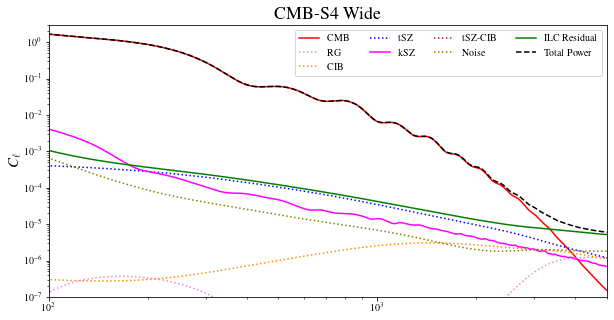

In [47]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(l, cl, label = 'CMB', color = 'red')
ax.set_title('CMB-S4 Wide', fontsize = 18)
ax.plot(l, res_ilc_dic_s4wide['radio'], label = 'RG', color = 'violet', ls = ':')
ax.plot(l, res_ilc_dic_s4wide['cib'], label = 'CIB', color = 'darkorange', ls = ':')
ax.plot(l, res_ilc_dic_s4wide['tsz'], label = 'tSZ', color = 'blue', ls = ':')
ax.plot(l, res_ilc_dic_s4wide['ksz'], label = 'kSZ', color = 'magenta')
ax.plot(l, res_ilc_dic_s4wide['tsz_cib'], label = 'tSZ-CIB', color = 'brown', ls = ':')
ax.plot(l, res_ilc_dic_s4wide['noise'], label = 'Noise', color = 'olive', ls = ':')
ax.plot(l, cl_residual_s4wide-res_ilc_dic_s4wide['ksz'], label = 'ILC Residual', color = 'green')
ax.plot(l, cl + cl_residual_s4wide, label = 'Total Power', color = 'black', ls = '--')
ax.set_ylabel(r'$C_{\ell}$', fontsize = 15)
ax.set_ylim(1e-7,1e3)
ax.legend(ncol=4, loc = 'best')
ax.set_ylim(-3., 3.);
ax.set_xlim(100, 5000);

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

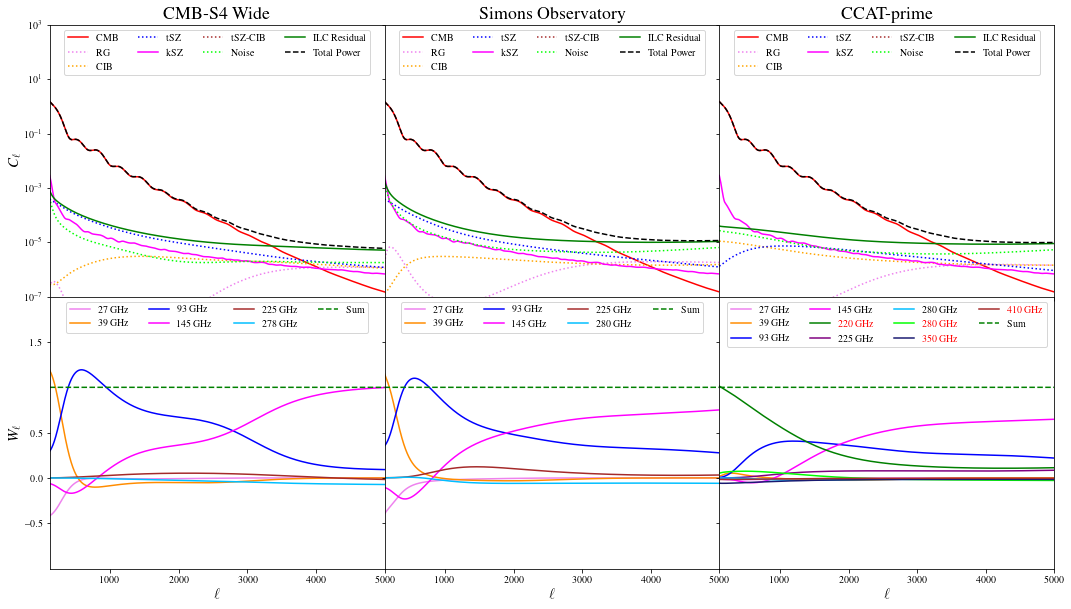

In [48]:
fig, axs = plt.subplots(2, 3, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(18,10))
(ax1, ax2, ax3), (ax4, ax5, ax6) = axs


ax1.set_yscale('log')
ax1.plot(l, cl, label = 'CMB', color = 'red')
ax1.set_title('CMB-S4 Wide', fontsize = 18)
ax1.plot(l, res_ilc_dic_s4wide['radio'], label = 'RG', color = 'violet', ls = ':')
ax1.plot(l, res_ilc_dic_s4wide['cib'], label = 'CIB', color = 'orange', ls = ':')
ax1.plot(l, res_ilc_dic_s4wide['tsz'], label = 'tSZ', color = 'blue', ls = ':')
ax1.plot(l, res_ilc_dic_s4wide['ksz'], label = 'kSZ', color = 'magenta')
ax1.plot(l, res_ilc_dic_s4wide['tsz_cib'], label = 'tSZ-CIB', color = 'brown', ls = ':')
ax1.plot(l, res_ilc_dic_s4wide['noise'], label = 'Noise', color = 'lime', ls = ':')
ax1.plot(l, cl_residual_s4wide-res_ilc_dic_s4wide['ksz'], label = 'ILC Residual', color = 'green')
ax1.plot(l, cl + cl_residual_s4wide, label = 'Total Power', color = 'black', ls = '--')
ax1.set_ylabel(r'$C_{\ell}$', fontsize = 15)
ax1.set_ylim(1e-7,1e3)
ax1.legend(ncol=4, loc = 'upper center')



ax2.plot(l, cl, label = 'CMB', color = 'red')
ax2.set_title('Simons Observatory', fontsize = 18)
ax2.plot(l, res_ilc_dic_so['radio'], label = 'RG', color = 'violet', ls = ':')
ax2.plot(l, res_ilc_dic_so['cib'], label = 'CIB', color = 'orange', ls = ':')
ax2.plot(l, res_ilc_dic_so['tsz'], label = 'tSZ', color = 'blue', ls = ':')
ax2.plot(l, res_ilc_dic_so['ksz'], label = 'kSZ', color = 'magenta')
ax2.plot(l, res_ilc_dic_so['tsz_cib'], label = 'tSZ-CIB', color = 'brown', ls = ':')
ax2.plot(l, res_ilc_dic_so['noise'], label = 'Noise', color = 'lime', ls = ':')
ax2.plot(l, cl_residual_so-res_ilc_dic_so['ksz'], label = 'ILC Residual', color = 'green')
ax2.plot(l, cl + cl_residual_so, label = 'Total Power', color = 'black', ls = '--')
ax2.legend(ncol=4, loc = 'upper center')




ax3.plot(l, cl, label = 'CMB', color = 'red')
ax3.set_title('CCAT-prime', fontsize = 18)
ax3.plot(l, res_ilc_dic_ccatp['radio'], label = 'RG', color = 'violet', ls = ':')
ax3.plot(l, res_ilc_dic_ccatp['cib'], label = 'CIB', color = 'orange', ls = ':')
ax3.plot(l, res_ilc_dic_ccatp['tsz'], label = 'tSZ', color = 'blue', ls = ':')
ax3.plot(l, res_ilc_dic_ccatp['ksz'], label = 'kSZ', color = 'magenta')
ax3.plot(l, res_ilc_dic_ccatp['tsz_cib'], label = 'tSZ-CIB', color = 'brown', ls = ':')
ax3.plot(l, res_ilc_dic_ccatp['noise'], label = 'Noise', color = 'lime', ls = ':')
ax3.plot(l, cl_residual_ccatp-res_ilc_dic_ccatp['ksz'], label = 'ILC Residual', color = 'green')
ax3.plot(l, cl + cl_residual_ccatp, label = 'Total Power', color = 'black', ls = '--')
ax3.legend(ncol=4, loc = 'upper center')


ax4.plot(l, weights_arr_s4wide[0], label = str(freq_arr_s4wide[0])+' GHz', color = 'violet')
ax4.plot(l, weights_arr_s4wide[1], label = str(freq_arr_s4wide[1])+' GHz', color = 'darkorange')
ax4.plot(l, weights_arr_s4wide[2], label = str(freq_arr_s4wide[2])+' GHz', color = 'blue')
ax4.plot(l, weights_arr_s4wide[3], label = str(freq_arr_s4wide[3])+' GHz', color = 'magenta')
ax4.plot(l, weights_arr_s4wide[4], label = str(freq_arr_s4wide[4])+' GHz', color = 'brown')
ax4.plot(l, weights_arr_s4wide[5], label = str(freq_arr_s4wide[5])+' GHz', color = 'deepskyblue')
tot = np.asarray(weights_arr_s4wide[0])+np.asarray(weights_arr_s4wide[1])+np.asarray(weights_arr_s4wide[2])+np.asarray(weights_arr_s4wide[3])+np.asarray(weights_arr_s4wide[4])+np.asarray(weights_arr_s4wide[5])
ax4.plot(l, tot, label = 'Sum', color = 'green', ls = '--')
ax4.set_xlim(115, 5000)
ax4.set_ylim(-1., 2.)
#ax4.set_xticks([1e1, 1e2, 1e3])
ax4.set_xlabel(r'$\ell$', fontsize = 15)
ax4.set_ylabel(r'$W_{\ell}$', fontsize = 15) 
ax4.set_yticks([-0.5, 0, 0.5, 1.5])
ax4.legend(ncol=4, loc = 'upper center')


ax5.plot(l, weights_arr_so[0], label = str(freq_arr_so[0])+' GHz', color = 'violet')
ax5.plot(l, weights_arr_so[1], label = str(freq_arr_so[1])+' GHz', color = 'darkorange')
ax5.plot(l, weights_arr_so[2], label = str(freq_arr_so[2])+' GHz', color = 'blue')
ax5.plot(l, weights_arr_so[3], label = str(freq_arr_so[3])+' GHz', color = 'magenta')
ax5.plot(l, weights_arr_so[4], label = str(freq_arr_so[4])+' GHz', color = 'brown')
ax5.plot(l, weights_arr_so[5], label = str(freq_arr_so[5])+' GHz', color = 'deepskyblue')
tot = np.asarray(weights_arr_so[0])+np.asarray(weights_arr_so[1])+np.asarray(weights_arr_so[2])+np.asarray(weights_arr_so[3])+np.asarray(weights_arr_so[4])+np.asarray(weights_arr_so[5])
ax5.plot(l, tot, label = 'Sum', color = 'green', ls = '--')
ax5.set_xlim(115, 5000)
#ax5.set_xticks([1e1, 1e2, 1e3])
ax5.legend(ncol=4, loc = 'upper center')
ax5.set_xlabel(r'$\ell$', fontsize = 15)


ax6.plot(l, weights_arr_ccatp[0], label = str(int(round(freq_arr_ccatp[0],0)))+' GHz', color = 'violet')
ax6.plot(l, weights_arr_ccatp[1], label = str(int(round(freq_arr_ccatp[1],0)))+' GHz', color = 'darkorange')
ax6.plot(l, weights_arr_ccatp[2], label = str(int(round(freq_arr_ccatp[2],0)))+' GHz', color = 'blue')
ax6.plot(l, weights_arr_ccatp[3], label = str(int(round(freq_arr_ccatp[3],0)))+' GHz', color = 'magenta')
ax6.plot(l, weights_arr_ccatp[4], label = str(int(round(freq_arr_ccatp[4],0)))+' GHz', color = 'green')
ax6.plot(l, weights_arr_ccatp[5], label = str(int(round(freq_arr_ccatp[5],0)))+' GHz', color = 'purple')
ax6.plot(l, weights_arr_ccatp[6], label = str(int(round(freq_arr_ccatp[6],0)))+' GHz', color = 'deepskyblue')
ax6.plot(l, weights_arr_ccatp[7], label = str(int(round(freq_arr_ccatp[7],0)))+' GHz', color = 'lime')
ax6.plot(l, weights_arr_ccatp[8], label = str(int(round(freq_arr_ccatp[8],0)))+' GHz', color = 'midnightblue')
ax6.plot(l, weights_arr_ccatp[9], label = str(int(round(freq_arr_ccatp[9],0)))+' GHz', color = 'brown')
tot = np.asarray(weights_arr_ccatp[0])+np.asarray(weights_arr_ccatp[1])+np.asarray(weights_arr_ccatp[2])+np.asarray(weights_arr_ccatp[3])+np.asarray(weights_arr_ccatp[4])+np.asarray(weights_arr_ccatp[5])+np.asarray(weights_arr_ccatp[6])+np.asarray(weights_arr_ccatp[7])+np.asarray(weights_arr_ccatp[8])+np.asarray(weights_arr_ccatp[9])                                                                                                                                        
ax6.plot(l, tot, label = 'Sum', color = 'green', ls = '--')
ax6.set_xlim(115, 5000)
#ax6.set_xticks([1e1, 1e2, 1e3])
ax6.set_xlabel(r'$\ell$', fontsize = 15)
ax6.legend(ncol=4, loc = 'upper center')
leg = ax6.legend(ncol=4, loc = 'upper center')
txts = []
for text in leg.get_texts():
    txts.append(text)
tx = []
tx.append(txts[4])
tx.append(txts[7])
tx.append(txts[8])
tx.append(txts[9])
for j in tx:
    plt.setp(j, color = 'red')

plt.savefig('residuals_and_weights.eps', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)

In [ ]:
map_arr_s4wide = []
for freq in freq_arr_s4wide:
    curr_map = cmb_maps_dic_s4wide[freq]
    map_arr_s4wide.append(curr_map)

    
map_arr_so = []
for freq in freq_arr_so:
    curr_map = cmb_maps_dic_so[freq]
    map_arr_so.append(curr_map)    

map_arr_ccatp = []
for freq in freq_arr_ccatp:
    curr_map = cmb_maps_dic_ccatp[freq]
    map_arr_ccatp.append(curr_map)    

    
_, extent = tools.make_grid([400, 0.25, 400, 0.25])
fig, axarr = plt.subplots(4,7, figsize=(15,15))



img00 = axarr[0,0].imshow(map_arr_s4wide[0], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img00, ax = axarr[0,0], shrink = 0.2)
axarr[0,0].set_title(str(freq_arr_s4wide[0])+' GHz', fontsize = '15')
axarr[0,0].set_ylabel(r'$\theta_y\ $'+'[arcmin]', fontsize = '15')
axarr[0,0].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
img01 = axarr[0,1].imshow(map_arr_s4wide[1], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img01, ax = axarr[0,1], shrink = 0.2)
axarr[0,1].set_title(str(freq_arr_s4wide[1])+' GHz', fontsize = '15')
axarr[0,1].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[0,1].get_yaxis().set_visible(False)
img02 = axarr[0,2].imshow(map_arr_s4wide[2], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img02, ax = axarr[0,2], shrink = 0.2)
axarr[0,2].set_title(str(freq_arr_s4wide[2])+' GHz', fontsize = '15')
axarr[0,2].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[0,2].get_yaxis().set_visible(False)
img03 = axarr[0,3].imshow(map_arr_s4wide[3], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img03, ax = axarr[0,3], shrink = 0.2)
axarr[0,3].set_title(str(freq_arr_s4wide[3])+' GHz', fontsize = '15')
axarr[0,3].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[0,3].get_yaxis().set_visible(False)
img04 = axarr[0,4].imshow(map_arr_s4wide[4], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img04, ax = axarr[0,4], shrink = 0.2)
axarr[0,4].set_title(str(freq_arr_s4wide[4])+' GHz', fontsize = '15')
axarr[0,4].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[0,4].get_yaxis().set_visible(False)
img05 = axarr[0,5].imshow(map_arr_s4wide[5], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img05, ax = axarr[0,5], shrink = 0.2)
axarr[0,5].set_title(str(freq_arr_s4wide[5])+' GHz', fontsize = '15')
axarr[0,5].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[0,5].get_yaxis().set_visible(False)
img06 = axarr[0,6].imshow(ilc_map_s4wide, extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img06, ax = axarr[0,6], shrink = 0.2).set_label(label=r'$T \ [\mu$'+'K]', size=15)
axarr[0,6].set_title('ILC Map', fontsize = '15')
axarr[0,6].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[0,6].get_yaxis().set_visible(False)


img10 = axarr[1,0].imshow(map_arr_so[0], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img10, ax = axarr[1,0], shrink = 0.2)
axarr[1,0].set_title(str(freq_arr_so[0])+' GHz', fontsize = '15')
axarr[1,0].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[1,0].set_ylabel(r'$\theta_y\ $'+'[arcmin]', fontsize = '15')
img11 = axarr[1,1].imshow(map_arr_so[1], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img11, ax = axarr[1,1], shrink = 0.2)
axarr[1,1].set_title(str(freq_arr_so[1])+' GHz', fontsize = '15')
axarr[1,1].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[1,1].get_yaxis().set_visible(False)
img12 = axarr[1,2].imshow(map_arr_so[2], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img12, ax = axarr[1,2], shrink = 0.2)
axarr[1,2].set_title(str(freq_arr_so[2])+' GHz', fontsize = '15')
axarr[1,2].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[1,2].get_yaxis().set_visible(False)
img13 = axarr[1,3].imshow(map_arr_so[3], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img13, ax = axarr[1,3], shrink = 0.2)
axarr[1,3].set_title(str(freq_arr_so[3])+' GHz', fontsize = '15')
axarr[1,3].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[1,3].get_yaxis().set_visible(False)
img14 = axarr[1,4].imshow(map_arr_so[4], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img14, ax = axarr[1,4], shrink = 0.2)
axarr[1,4].set_title(str(freq_arr_so[4])+' GHz', fontsize = '15')
axarr[1,4].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[1,4].get_yaxis().set_visible(False)
img15 = axarr[1,5].imshow(map_arr_so[5], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img15, ax = axarr[1,5], shrink = 0.2)
axarr[1,5].set_title(str(freq_arr_so[5])+' GHz', fontsize = '15')
axarr[1,5].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[1,5].get_yaxis().set_visible(False)
img16 = axarr[1,6].imshow(ilc_map_so, extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img16, ax = axarr[1,6], shrink = 0.2).set_label(label=r'$T \ [\mu$'+'K]', size=15)
axarr[1,6].set_title('ILC Map', fontsize = '15')
axarr[1,6].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[1,6].get_yaxis().set_visible(False)


img20 = axarr[2,0].imshow(map_arr_ccatp[0], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img21, ax = axarr[2,0], shrink = 0.2)
axarr[2,0].set_title(str(freq_arr_ccatp[0])+' GHz', fontsize = '15')
axarr[2,0].set_ylabel(r'$\theta_y\ $'+'[arcmin]', fontsize = '15')
axarr[2,0].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
img21 = axarr[2,1].imshow(map_arr_ccatp[1], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img21, ax = axarr[2,1], shrink = 0.2)
axarr[2,1].set_title(str(freq_arr_ccatp[1])+' GHz', fontsize = '15')
axarr[2,1].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[2,1].get_yaxis().set_visible(False)
img22 = axarr[2,2].imshow(map_arr_ccatp[2], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img22, ax = axarr[2,2], shrink = 0.2)
axarr[2,2].set_title(str(freq_arr_ccatp[2])+' GHz', fontsize = '15')
axarr[2,2].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[2,2].get_yaxis().set_visible(False)
img23 = axarr[2,3].imshow(map_arr_ccatp[3], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img23, ax = axarr[2,3], shrink = 0.2)
axarr[2,3].set_title(str(freq_arr_ccatp[3])+' GHz', fontsize = '15')
axarr[2,3].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[2,3].get_yaxis().set_visible(False)
img24 = axarr[2,4].imshow(map_arr_ccatp[4], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img24, ax = axarr[2,4], shrink = 0.2)
axarr[2,4].set_title(str(freq_arr_ccatp[4])+' GHz', fontsize = '15')
axarr[2,4].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[2,4].get_yaxis().set_visible(False)
img25 = axarr[2,5].imshow(map_arr_ccatp[5], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img25, ax = axarr[2,5], shrink = 0.2)
axarr[2,5].set_title(str(freq_arr_ccatp[5])+' GHz', fontsize = '15')
axarr[2,5].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[2,5].get_yaxis().set_visible(False)
img26 = axarr[2,6].imshow(ilc_map_ccatp, extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img26, ax = axarr[2,6], shrink = 0.2).set_label(label=r'$T \ [\mu$'+'K]', size=15)
axarr[2,6].set_title('ILC Map', fontsize = '15')
axarr[2,6].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[2,6].get_yaxis().set_visible(False)


img30 = axarr[3,0].imshow(map_arr_ccatp[6], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img21, ax = axarr[3,0], shrink = 0.2)
axarr[3,0].set_title(str(int(round(freq_arr_ccatp[6], 0)))+' GHz', fontsize = '15')
axarr[3,0].set_ylabel(r'$\theta_y\ $'+'[arcmin]', fontsize = '15')
axarr[3,0].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
img31 = axarr[3,1].imshow(map_arr_ccatp[7], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img21, ax = axarr[3,1], shrink = 0.2)
axarr[3,1].set_title(str(freq_arr_ccatp[7])+' GHz', fontsize = '15')
axarr[3,1].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[3,1].get_yaxis().set_visible(False)
img32 = axarr[3,2].imshow(map_arr_ccatp[8], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img22, ax = axarr[3,2], shrink = 0.2)
axarr[3,2].set_title(str(freq_arr_ccatp[8])+' GHz', fontsize = '15')
axarr[3,2].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[3,2].get_yaxis().set_visible(False)
img33 = axarr[3,3].imshow(map_arr_ccatp[9], extent = extent, cmap = cm.RdBu_r)
fig.colorbar(img23, ax = axarr[3,3], shrink = 0.2)
axarr[3,3].set_title(str(freq_arr_ccatp[9])+' GHz', fontsize = '15')
axarr[3,3].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
axarr[3,3].get_yaxis().set_visible(False)
axarr[3,4].set_visible(False)
axarr[3,5].set_visible(False)
axarr[3,6].set_visible(False)



fig.subplots_adjust(wspace=0.9, hspace = -0.4)


axarr[0,3].text(-70, 105, 'CMB-S4 Wide', fontsize = 18)
axarr[1,3].text(-90, 105, 'Simons Observatory', fontsize = 18)
axarr[2,3].text(-60, 105, 'CCAT-prime', fontsize = 18)
plt.savefig('multifrequency_maps.eps', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)

In [ ]:
experiments = ['S4-Wide', 'SO', 'CCAT-p']
snr_arr = [5,5,4]
plt.plot(experiments, snr_arr, ls = '', marker = 'o')
plt.savefig('forecasts.eps', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)